In [2]:
using Revise, Pkg
Pkg.activate("../.")
using DataFrames, VegaLite, VegaDatasets
using Distributions, KernelDensity
using LightGraphs, GraphPlot, SimpleWeightedGraphs, LinearAlgebra, DataFrames, Random, Colors

 Activating environment at `~/MEGAsync/EMAp/VegaGraphs/Project.toml`
┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1278


In [3]:
Random.seed!(7)
df = DataFrame(rand([0,1],10,20));

In [4]:
function gen_graph(df)
    g = SimpleWeightedGraph(ncol(df))
    ew = Int[]
    pairings = [] 
    for i in 1:ncol(df), j in i+1:ncol(df) # iterate over all combinations of columns
        w = dot(df[!, i], df[!, j])        # calculate how many times (i,j) occurs
        if w > 0
            push!(ew, w)
            add_edge!(g, i, j, w)
            push!(pairings,[i,j])
        end
    end
#     gplot(g,nodelabel=names(df),edgelinewidth=ew)
#     gplot(g)
    return (g,ew)
end

function get_edges(g,node_x,node_y)
    edges_p1 = []
    edges_p2 = []
    edges_w  = Float64[]
    for i in edges(g)
        push!(edges_p1, i.src)
        push!(edges_p1, i.src)
        push!(edges_p2, i.dst)
        push!(edges_p2, i.dst)
        push!(edges_w, i.weight)
        push!(edges_w, i.weight)
    end
    
    edges_node  = Int[]
    edges_pairs = []
    for i in 1:size(edges_p1)[1]
        if i % 2 == 0
            push!(edges_node,edges_p2[i])
        else
            push!(edges_node,edges_p1[i])
        end
        push!(edges_pairs,[edges_p1[i],edges_p2[i]])
    end 
    graph_edges = DataFrame(edges_x = node_x[edges_node], edges_y = node_y[edges_node],
                       pairs = edges_pairs, ew = edges_w, node = edges_node) 
    return graph_edges
end

get_edges (generic function with 1 method)

In [5]:
g,ew = gen_graph(df)
node_x, node_y = GraphPlot.spring_layout(g);
graph_edges = get_edges(g,node_x,node_y);
graph_edges[:ew] = graph_edges[:ew]/10;
graph_nodes = DataFrame(keywords = names(df),node_x=node_x, node_y=node_y,centrality=betweenness_centrality(g));

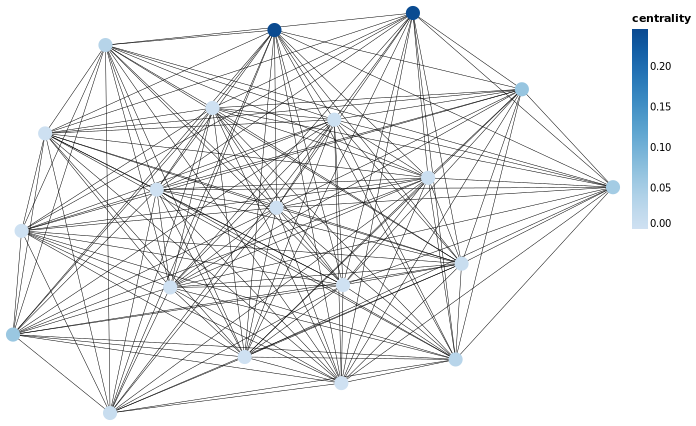

In [6]:
v1 =@vlplot(
    mark={"type"=:circle,clip=false,opacity=1},
    data = graph_nodes,
    x={"node_x:q",axis=nothing},
    y={"node_y:q",axis=nothing},
    size={value=200,legend=nothing},
    color={"centrality:q", scale={scheme="blues"}},
    tooltip=[{field="keywords","type"="nominal"}],
    width=600,
    height=400,
    selection={
        grid={
                type=:interval,
                bind=:scales,
            }
    }
)

v2 =@vlplot(
    mark={"type"=:line,color="black",clip=false,size=0.5},
    data = graph_edges,
    encoding={
    x={"edges_x:q",axis=nothing},
    y={"edges_y:q",axis=nothing},
#     size={"ew:q",legend=nothing},
    detail={"pairs:o"}},
    width=600,
    height=400
);

graph_plot = @vlplot(view={stroke=nothing})+v2+v1

In [7]:
# @set graph_plot.layer[1]["mark"]["type"] = :trail
vv = @vlplot() + v2
vv.layer[1]["mark"]

OrderedCollections.OrderedDict{String,Any} with 4 entries:
  "type"  => :line
  "color" => "black"
  "clip"  => false
  "size"  => 0.5